# How To Identify Customer Segmentation
**Using RFM Analysis**

Angewandte Programmierung, sonst. Beteiligung (25%)

This notebook aims at analyzing the content of a real E-Commerce database that lists purchases made by  ∼ 25,500 customers over a period from November 2018 to April 2019. Based on this analysis, I develop a RFM model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase

# Table of Contents
- [Introduction](#intro)
- [Step l: Data Importing and Cleaning](#s1)
- [Step 2: Create RFM Anaylses for each customers](#s2)
- [Step 3: Calculate RFM score and level](#s3)
- [Step 4: Visualize the Value Matrix and explore some key numbers](#s4)
- [Conclusion](#conc)

 <img src="imgs/segmentation.jpg" width=300 height=300 style="float:left" />

<a id='intro'></a>

# Introduction 


**What is RFM?**

RFM (Recency Frequency Monetary) analysis or RFM segmentation is an effective marketing technique to identify your best customers. Instead of reaching out to 100% of your audience, target only specific customer segments that can prove beneficial for your business in future. 

- **Recency (R)** – How many days ago customer made a purchase? Deduct most recent purchase date from today to calculate the recency value. 1, 14 or 500 days ago?
- **Frequency (F)** – How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.
- **Monetary (M)** – How many $$ (or whatever is your currency of calculation) has this customer spent? Simply total up the money from all transactions to get the M value.

Customers with the most recent purchase, more transactions and spending more money are assigned higher values.

<img src="imgs/RFM.png" width=300 height=300 style="float:left"/>


<a id='s1'></a>

# Step 1:
## Data Importing and Cleaning
We will be analyzing our online shopper data set again, but this time with our RFM model.

In [1]:
# Import liberaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

In [2]:
# load data into a dataframe
df = pd.read_csv('e-commerce.csv')
string_to_date = lambda x : datetime.strptime(x, "%d/%m/%Y").date()

# Convert InvoiceDate from object to datetime format
df['day'] = df['day'].apply(string_to_date)
df['day'] = df['day'].astype('datetime64[ns]')

df.head()

,product_title,product_type,variant_title,variant_sku,variant_id,customer_id,order_id,day,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,returned_item_quantity,ordered_item_quantity
0,DPR,DPR,100,AD-982-708-895-F-6C894FB,52039657,1312378,83290718932496,2018-12-04,2,200.0,-200.00,0.00,0.0,0.0,0.0,0,2
1,RJF,Product P,28 / A / MTM,83-490-E49-8C8-8-3B100BC,56914686,3715657,36253792848113,2019-04-01,2,190.0,-190.00,0.00,0.0,0.0,0.0,0,2
2,CLH,Product B,32 / B / FtO,68-ECA-BC7-3B2-A-E73DE1B,24064862,9533448,73094559597229,2018-11-05,0,164.8,-156.56,-8.24,0.0,0.0,0.0,-2,2
3,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,53616575668264,2019-02-19,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1
4,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,29263220319421,2019-02-19,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1


Let’s take a closer look at the data we will need to manipulate.

In [3]:
# Drop NA values
df.dropna()

print('{:,} rows; {:,} columns'.format(df.shape[0], df.shape[1]))
print('Transactions timeframe from {} to {}'.format(df['day'].min(), df['day'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.customer_id.isnull()].shape[0]))
print('{:,} unique customer_id'.format(len(df.customer_id.unique())))


70,052 rows; 17 columns
Transactions timeframe from 2018-11-01 00:00:00 to 2019-04-30 00:00:00
0 transactions don't have a customer id
25,543 unique customer_id


<a id='s2'></a>
# Step 2:
## Create RFM Anaylses for each customers

The first we need to do is to sort customers based on recency, frequency, and monetary values
To calculate recency, we will be taking one day after the last invoice date of our data set as the snapshot date ‘2019-12-04’.
The date difference will give us how recent the last transaction was made.With that, we can then group our dateframe by customer_id and assign it to ‘data_process’ for our data pre-processing.

In [4]:
# Convert string to date

max_date = df['day'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)

df_RFM = df.groupby('customer_id').agg({'day': Recency,
                                        'order_id': Frequency,  
                                        'gross_sales': Monetary })

df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
print(df_RFM.head())
print('{:,} rows; {:,} columns'.format(df_RFM.shape[0], df_RFM.shape[1]))

             Recency  Frequency  Monetary
customer_id                              
8325158            4         17   2812.58
2028611           98         17   2661.72
6578818            5         16   2486.73
7843272            0         20   2325.06
8032770           50         13   2065.88
25,543 rows; 3 columns


Great, we have 25543 customer records grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. Now we can get into the meat of things and use the .qcut() method to assign the relative percentile to their RFM features. But before that, let’s examine the distribution of our Recency, Frequency, and Monetary.

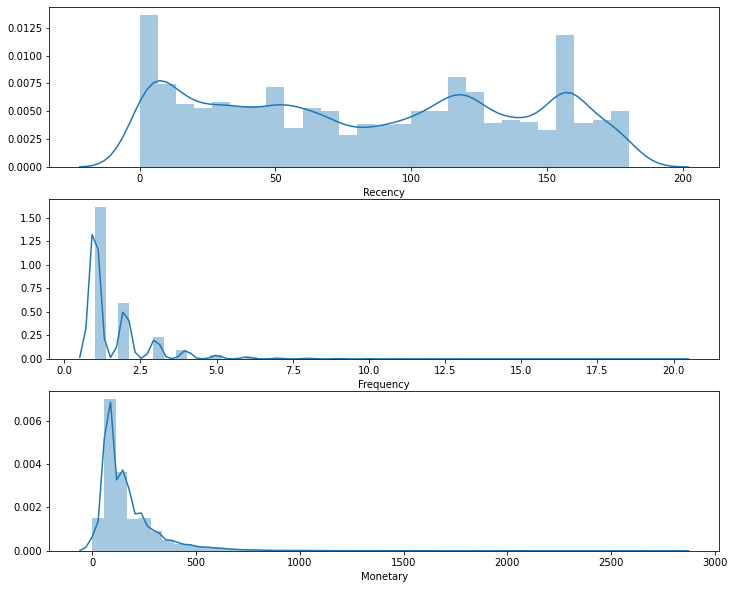

In [5]:
# Plot RFM distributions
plt.figure(figsize=(12,10))# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_RFM['Recency'])# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_RFM['Frequency'])# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_RFM['Monetary'])# Show the plot
plt.show()

<a id='s2'></a>

# Step 2:
## Calculate R, F and M groups
This plot provides us with some very interesting insights and how skewed our data is. The important thing to take note here is that we will be grouping these values in quantiles. However, when we examine our customer segmentation using K-Means in the next, it will be very important to ensure that we scale our data to center the mean and standard deviations. More on that next time. Let us proceed with the .qcut() for our RFM.

We create a 4 labels for our f_labels, where 4 is the “best” quantile. We do the same for our f_label. We then create new columns “R” and “F” and assign the r_group and f_group values to them respectively.

Next, we do the same for our monetary value by grouping the values into 4 quantiles using .qcut() method.


In [6]:

# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5); m_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

# Create new columns R and F 
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
8325158,4,17,2812.58,4,4,4
2028611,98,17,2661.72,2,4,4
6578818,5,16,2486.73,4,4,4
7843272,0,20,2325.06,4,4,4
8032770,50,13,2065.88,3,4,4


Finally, with these 3 scores in place, R, F, and M, we can create our first RFM segment by concatenating the values together below.

In [7]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
customer_id,,,,,,,
8325158,4,17,2812.58,4,4,4,444
2028611,98,17,2661.72,2,4,4,244
6578818,5,16,2486.73,4,4,4,444
7843272,0,20,2325.06,4,4,4,444
8032770,50,13,2065.88,3,4,4,344


From the output, you can see that we have our concatenated segments ready to be used for our segmentation, but there is one issue…

In [8]:
# Count num of unique segments
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

48


Having 48 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

<a id='s3'></a>

# Step 3:
## Calculate RFM score and level 

**Summing the Score**

One of the most straightforward methods is to sum our scores to a single number and define RFM levels for each score range.

In [9]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,
8325158,4,17,2812.58,4,4,4,444,12.0
2028611,98,17,2661.72,2,4,4,244,10.0
6578818,5,16,2486.73,4,4,4,444,12.0
7843272,0,20,2325.06,4,4,4,444,12.0
8032770,50,13,2065.88,3,4,4,344,11.0


We can get creative and hypothesize about what each score range entails, but for this exercise I will take inspiration from some common segment names.

In [10]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Stars'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'# Create a new variable RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)# Print the header with top 5 rows to the console
df_RFM[::2000]

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_id,,,,,,,,,
8325158,4,17,2812.58,4,4,4,444,12.0,Stars
4193770,0,5,380.85,4,4,4,444,12.0,Stars
4597386,2,2,270.82,4,3,4,434,11.0,Stars
3382250,131,2,222.52,2,3,4,234,9.0,Stars
6258536,107,3,172.50,2,4,3,243,9.0,Stars
7214317,125,1,156.67,2,1,3,213,6.0,Potential
6860385,4,2,148.32,4,4,3,443,11.0,Stars
7792319,124,1,106.67,2,1,2,212,5.0,Promising
1586258,147,1,82.50,1,1,2,112,4.0,Needs Attention


In [11]:
df_RFM['RFM_Level'].value_counts()

Stars              8539
Potential          4271
Promising          4015
Loyal              3482
Champions          2867
Needs Attention    2369
Name: RFM_Level, dtype: int64

<a id='s4'></a>

# Step 4:
## Visualize the Value Matrix and explore some key numbers

In [12]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)
# Print the aggregated dataset
rfm_agg

,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
RFM_Level,,,,,
Champions,61.0,1.0,146.0,2867,11.22
Loyal,55.0,1.0,109.0,3482,13.63
Needs Attention,158.0,1.0,82.0,2369,9.27
Potential,99.0,1.0,95.0,4271,16.72
Promising,141.0,1.0,89.0,4015,15.72
Stars,48.0,3.0,301.0,8539,33.43


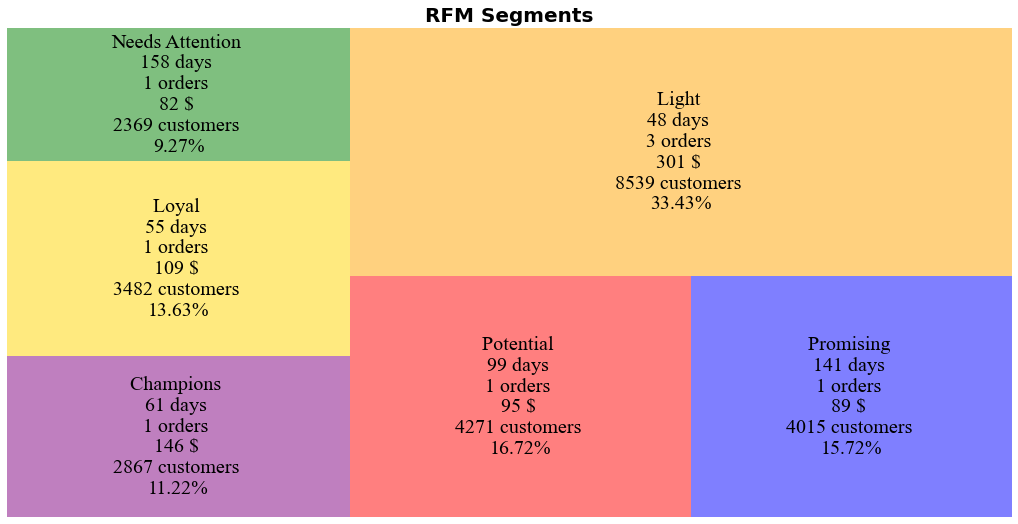

In [13]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(18, 9)

color_list = ['purple','gold','green','red','blue','orange']

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':20,'weight':'bold', 'fontname':"Times New Roman"},
              color=color_list,
              label=['Champions \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers \n{}%'.format(*rfm_agg.iloc[0]),
                     'Loyal \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers \n{}%'.format(*rfm_agg.iloc[1]),
                     'Needs Attention \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers \n{}%'.format(*rfm_agg.iloc[2]),
                     'Potential \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers \n{}%'.format(*rfm_agg.iloc[3]),
                     'Promising \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers \n{}%'.format(*rfm_agg.iloc[4]),
                     'Light \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers \n{}%'.format(*rfm_agg.iloc[5]),
                   ], alpha=0.5 )

plt.title("RFM Segments",fontsize=20,fontweight="bold")
plt.axis('off')
plt.savefig('imgs/RFM Segments.png')
plt.show()

# 3d plot

In [16]:
import plotly.express as px

fig = px.scatter_3d(df_RFM, x='R', y='F', z='M',
                   color = 'RFM_Level', opacity=0.5)
#fig.show()
fig.update_traces(marker=dict(size=10),
                  selector=dict(mode='markers'))
# tight layout
fig.show()
#symbol = 'RFM_Level', 

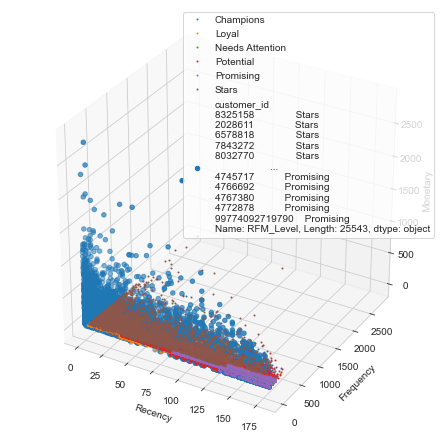

In [53]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = df_RFM['Recency']
y = df_RFM['Frequency']
z = df_RFM['Monetary']
c = df_RFM['RFM_Level']

groups = df_RFM.groupby('RFM_Level')


ax.scatter(x, y, z, label=c, marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

for name, group in groups:
    ax.plot(group.Recency, group.Monetary, marker='o', linestyle='', ms=1, label=name)
    
ax.legend()
plt.show()

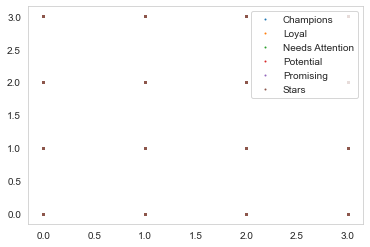

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(1974)

# Generate Data
x = df_RFM['R']
y = df_RFM['F']
z = df_RFM['Monetary']
c = df_RFM['RFM_Level']

groups = groups = df_RFM.groupby('RFM_Level')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(x, y, marker='o', linestyle='', ms=1, label=name)
ax.legend()

plt.show()

In [39]:
df_RFM.groupby('RFM_Level').count()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
RFM_Level,,,,,,,,
Champions,2867,2867,2867,2867,2867,2867,2867,2867
Loyal,3482,3482,3482,3482,3482,3482,3482,3482
Needs Attention,2369,2369,2369,2369,2369,2369,2369,2369
Potential,4271,4271,4271,4271,4271,4271,4271,4271
Promising,4015,4015,4015,4015,4015,4015,4015,4015
Stars,8539,8539,8539,8539,8539,8539,8539,8539


In [52]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

NameError: name 'rfm' is not defined

In [ ]:
#Seaborn pair plot

sns.pairplot(df_RFM, hue='Recency')

 <img src="imgs/3d plot.png" width=1000 height=1000 style="float:left" />

<a id='conc'></a>

# Conclusion

From here, we can see that a large percentage (~60%) of our customers are in the top tier RFM levels. The store must be doing something right to be maintaining their loyalty!

The other 40% will need some work. Let’s explore using some ads to re-target them:
1. **Champons Customers**: Bought recently, buy often and spend the most!
2. **Can’t Lose Them**: Made biggest purchases, and often. But haven’t returned for a long time. 	
1. **Loyal Customers**: Spend good money with us often. Responsive to promotions.
1. **Potential**: Recent customers, but spent a good amount and bought more than once.
2. **Promising**: Recent shoppers, but haven’t spent much.	
3. **Moving Away**: made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
4. **Require Activation**: Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

THE 11 POSSIBLE SEGMENTS AND ACTIONS
1. Champions - Reward them. Ask them for reviews. They can be early adopters for new products.

2. Loyal Customers - Up-sell higher value products. Ask for reviews. Ask for referrals, Engage with them; send them free gifts, pizzas, hand-written cards etc.

3. Promising - Offer subscription and loyalty programs. Provide recommendations. Ask for reviews. Send gifts, handwritten cards, etc. Make one-on-one personalized phone calls.

4. New Customers - Provide post-sale support. Give them early success, offer free gift cards. Start a one-on-one relationship.

5. Abandoned Checkouts - Provide pre-sale support. Start building a relationship. Learn their wants/needs.

6. Warm Leads - Reach out personally and provide proactive support. Learn about them and build a relationship.

7. Cold Leads - Reach out personally through email or SMS to revive interest. Learn about their passion/problem.

8. Need Attention - Make limited time offers. Recommend new products or services based on past purchases. Try to re-sell or cross-sell.

9. Shouldn't Lose - Win back through special offers. Talk to them, survey them, don't lose them to competitors.

10. Sleepers - Send personal emails and messages to reconnect. Provide helpful resources.

11. Lost - Try to revive interest with reach-out campaign, otherwise ignore.


<img src = "https://uploads-ssl.webflow.com/5bfc651298ce06e68a4fcc5f/5c09b34ca4a5b04163124182_RFM%20Customer%20Segmentation%20Map.png"/>

<img src = "https://uploads-ssl.webflow.com/5bfc651298ce06e68a4fcc5f/5c09b35cd457987390b70b7c_11%20RFM%20Customer%20Segments%20-%20Retail.png"/>


# Bibliography


- <a href = https://www.putler.com/docs/rfm-segmentation/>How to identify your best coustomer using RFM Segmentaion</a>

<tbody>
<tr>
<td>New Subscribers</td>
<td>These are identifiable customers who very recently joined your email marketing list, but haven’t purchased yet.</td>
</tr>
<tr>
<td>Window Shoppers</td>
<td>These are identifiable customers who have never purchased but are spending time browsing product detail pages.</td>
</tr>
<tr>
<td>Hot Prospects</td>
<td>These are potential customers with the highest levels of purchase intent. They are adding to cart, potentially abandoning transactions, and appear to be ready to buy.</td>
</tr>
<tr>
<td>Champions</td>
<td>There are your most loyal customers. They are your big spenders, purchase the most frequently, and have very high recency.</td>
</tr>
<tr>
<td>Regulars</td>
<td>These are great customers who purchase regularly and frequently. They are on their way to becoming Champions.</td>
</tr>
<tr>
<td>Potential Regulars</td>
<td>These are customers who have purchased recently, more than once, and are on their way to becoming better customers.</td>
</tr>
<tr>
<td>New Customers</td>
<td>These are new customers who have purchased recently, but only once.</td>
</tr>
<tr>
<td>Promising</td>
<td>These are also new customers who have purchased recently but spent a little bit more or more than once in a short period of time.</td>
</tr>
<tr>
<td>Cooling Down</td>
<td>These customers were once Regulars or Champions, but have decelerated their purchasing activity. This group needs attention.</td>
</tr>
<tr>
<td>At Risk</td>
<td>These are customers with above average recency, frequency, and monetary characteristics but are well past the point of abnormal purchase recency. You don’t have much time left to re-engage these folks.</td>
</tr>
<tr>
<td>Highly at Risk</td>
<td>These are formerly high-value customers who are in the final stage of defection. If we don’t market to them now, it’s likely that we’ll lose these customers forever.</td>
</tr>
<tr>
<td>Lost/Ignore</td>
<td>These are customers with low frequency, low recency and low monetary scores. Don’t invest marketing resources or attention here.</td>
</tr>
</tbody>

In [48]:
for i in ['R','F', 'M']:
    for j in ['l', 'm', 'h']:
        print(i+j)

Rl
Rm
Rh
Fl
Fm
Fh
Ml
Mm
Mh


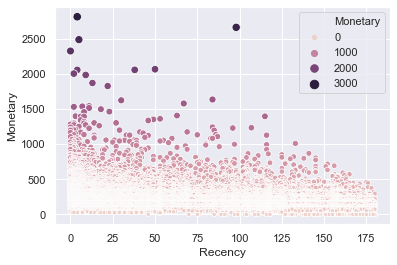

In [91]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
scaler = lambda x : x-
x = df_RFM['R']
y = df_RFM['F']
z = df_RFM['Monetary']
c = df_RFM['RFM_Level']

#ax = sns.scatterplot(x="Recency", y="Frequency", data=df_RFM)


ax = sns.scatterplot(x="Recency", y="Monetary",
                     hue="Monetary", size="Monetary",
                     data=df_RFM)

In [73]:
df_RFM

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_id,,,,,,,,,
8325158,4,17,2812.58,4,4,4,444,12.0,Stars
2028611,98,17,2661.72,2,4,4,244,10.0,Stars
6578818,5,16,2486.73,4,4,4,444,12.0,Stars
7843272,0,20,2325.06,4,4,4,444,12.0,Stars
8032770,50,13,2065.88,3,4,4,344,11.0,Stars
...,...,...,...,...,...,...,...,...,...
4745717,167,1,0.00,1,3,1,131,5.0,Promising
4766692,169,1,0.00,1,3,1,131,5.0,Promising
4767380,179,1,0.00,1,3,1,131,5.0,Promising
